In [1]:
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# Sets
T = [str(i) for i in range(1, 25)]
I = ["c1", "c2", "c3", "c4", "c5"]
J = ["V1", "V2", "V3"]

# Parameters
A = {
    ("c1", "V1"): -1, ("c1", "V2"): 1, ("c1", "V3"): 0,
    ("c2", "V1"): 1, ("c2", "V2"): -1, ("c2", "V3"): 0,
    ("c3", "V1"): 0, ("c3", "V2"): -1, ("c3", "V3"): 1,
    ("c4", "V1"): 0, ("c4", "V2"): 0, ("c4", "V3"): -1,
    ("c5", "V1"): 0, ("c5", "V2"): -1, ("c5", "V3"): 1,
}
k = {"c1": 1.0, "c2": -1.7, "c3": 1.1, "c4": 0.9, "c5": 0}
q_max = {"c1": 100, "c2": 50, "c3": 150, "c4": 120, "c5": 50}
v_init = {"V1": 100, "V2": 1000, "V3": 1000}
v_max = {"V1": 1000, "V2": 2000, "V3": 2000}
v_min = {"V1": 0, "V2": 500, "V3": 500}
Fj_t = {(j, t): 1 for j in J for t in T}
cart = {str(h): d for h, d in [(str(hour), 50) for hour in range(1, 7)] +
                             [(str(hour), 100) for hour in range(7, 19)] +
                             [(str(hour), 50) for hour in range(19, 25)]}
WP = {str(h): 0 for h in range(1, 25)}
lambda_t = {str(h): 1 for h in range(1, 25)}
mu_t = {str(h): 3 for h in range(1, 25)}

# Model
m = Model("HydroWindOptimization")

# Variables
q = m.addVars(I, T, name="q", lb=0)
v = m.addVars(J, T, name="v", lb=0)
buy = m.addVars(T, name="buy", lb=0)
sell = m.addVars(T, name="sell", lb=0)

# Flow and storage limits
for i in I:
    for t in T:
        m.addConstr(q[i, t] <= q_max[i], f"FlowLimit_{i}_{t}")

for j in J:
    for t in T:
        m.addConstr(v[j, t] <= v_max[j], f"StorageLimit_{j}_{t}")
    m.addConstr(v[j, "24"] >= v_min[j], f"FinalStorage_{j}")

# Reservoir balance
for j in J:
    for idx, t in enumerate(T):
        inflow = Fj_t[j, t]
        previous_v = v_init[j] if t == "1" else v[j, T[idx - 1]]
        m.addConstr(v[j, t] == previous_v + inflow + quicksum(A[i, j] * q[i, t] for i in I), f"ReservoirBalance_{j}_{t}")

# Power balance
for t in T:
    m.addConstr(quicksum(k[i] * q[i, t] for i in I) + WP[t] + buy[t] - sell[t] == cart[t], f"PowerBalance_{t}")

# Objective
m.setObjective(quicksum(lambda_t[t] * sell[t] - mu_t[t] * buy[t] for t in T), GRB.MAXIMIZE)

# Optimize
m.optimize()

Set parameter Username
Set parameter LicenseID to value 2670459
Academic license - for non-commercial use only - expires 2026-05-24
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 291 rows, 240 columns and 696 nonzeros
Model fingerprint: 0x296e35ec
Coefficient statistics:
  Matrix range     [9e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 204 rows and 13 columns
Presolve time: 0.00s
Presolved: 87 rows, 227 columns, 475 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9200000e+32   3.133333e+31   1.920000e+02      0s
     103    9.1600000e+01   0.000000e+00   0.000000e+00      0s

Solved in 103 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.160000000e+01


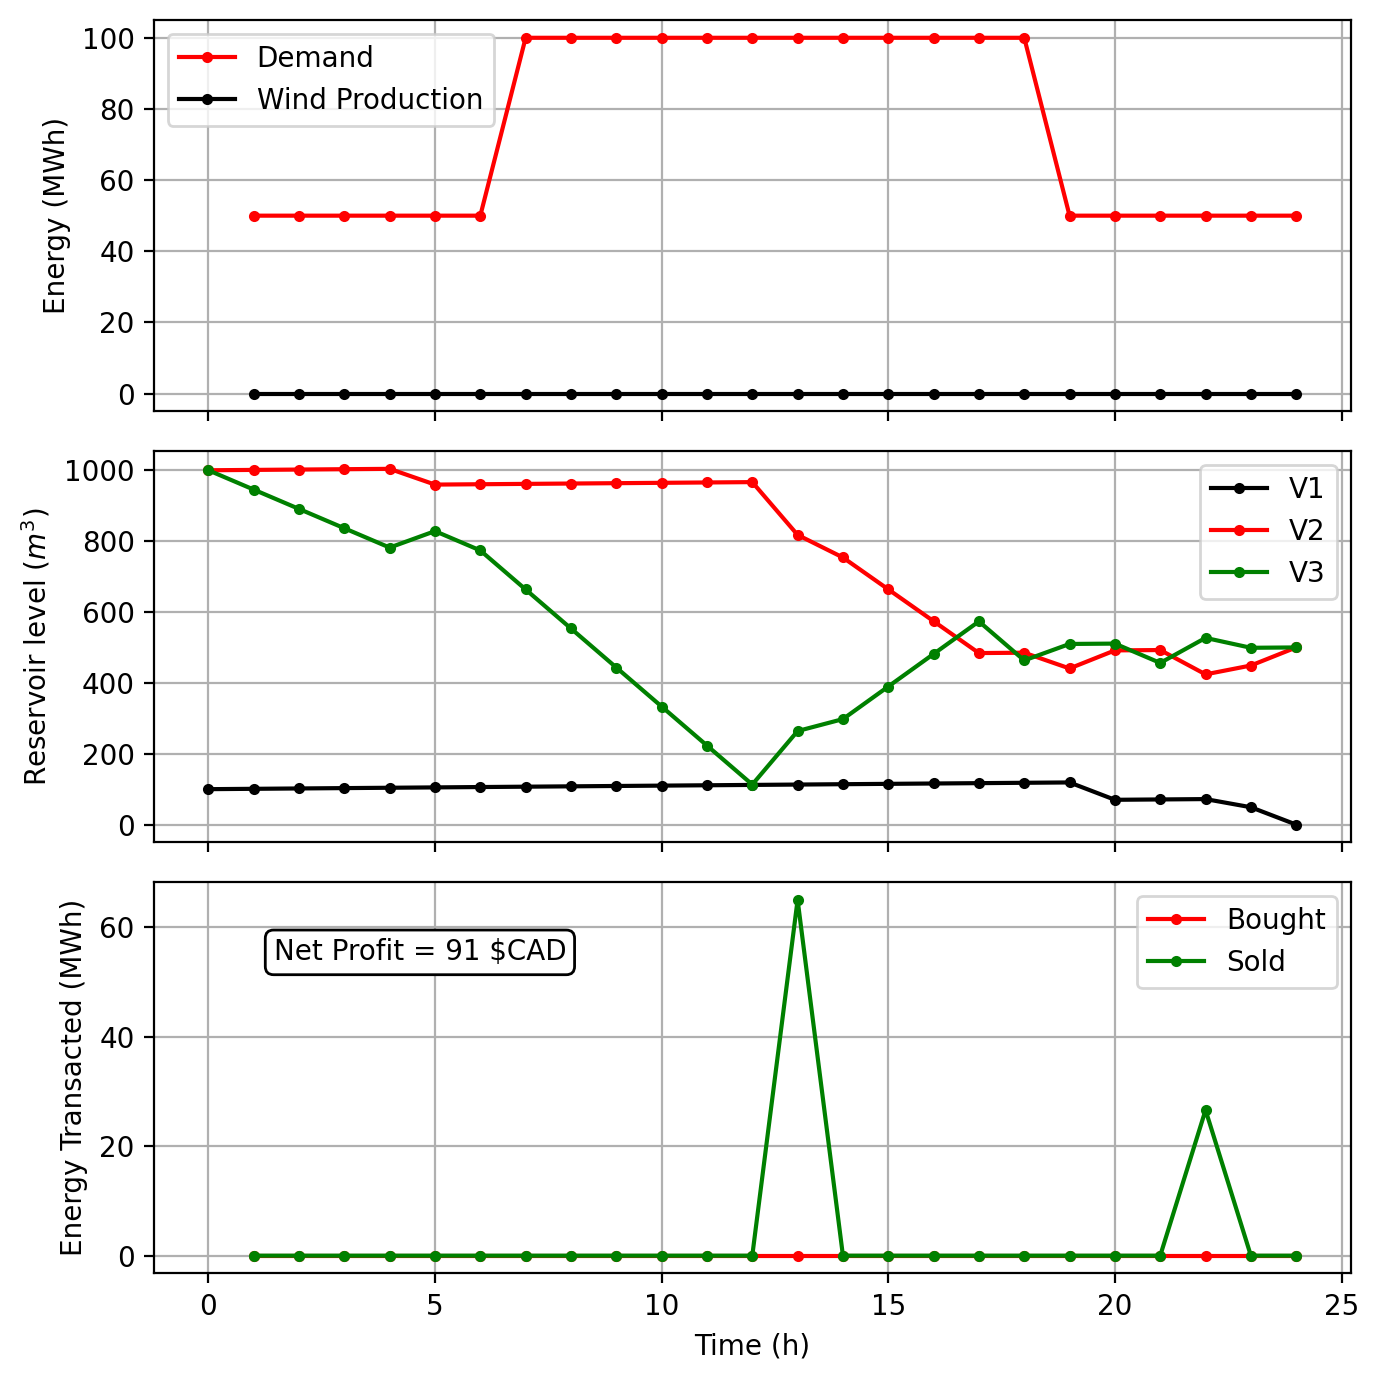

In [ ]:
# Create a figure and three subplots vertically with shared x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 7), sharex=True, dpi=200)

# Plot data on each subplot
axs[0].plot(range(1,25), [cart[t] for t in T], "-r.", label="Demand")
axs[0].plot(range(1,25), [WP[t] for t in T], "-k.", label="Wind Production")
axs[0].set_ylabel('Energy (MWh)')
axs[0].legend()
axs[0].grid()


axs[1].plot(range(0, 25),
    pd.concat([pd.Series([v_init["V1"]]), pd.Series([v["V1", t].X for t in T])]), "-k.", label="V1")
axs[1].plot(range(0, 25),
    pd.concat([pd.Series([v_init["V2"]]), pd.Series([v["V2", t].X for t in T])]), "-r.", label="V2")
axs[1].plot(range(0, 25),
    pd.concat([pd.Series([v_init["V3"]]), pd.Series([v["V3", t].X for t in T])]), "-g.", label="V3")
axs[1].set_ylabel(r'Reservoir level $(m^3)$')
axs[1].legend()
axs[1].grid()

axs[2].plot(range(1,25), [buy[t].X for t in T], "-r.", label="Bought")
axs[2].plot(range(1,25), [sell[t].X for t in T], "-g.", label="Sold")
axs[2].annotate(f"Net Profit = {int(m.ObjVal)} \$CAD", xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
axs[2].set_ylabel('Energy Transacted (MWh)')
axs[2].set_xlabel('Time (h)')
axs[2].legend()
axs[2].grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# axs[0].set_title(r"Case 2: Last hour min storage constraint $0\le V_{1,T}$, $500\le V_{2,T},V_{3,T}$")
# plt.xticks(np.arange(min(range(1,25)), max(range(1,25))+1))
plt.show()


